<a href="https://colab.research.google.com/github/duartemoura/mastersprojects/blob/main/CaliforniaHousingAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing Dataset Analysis

----------------------------------------------------
Introduction to Machine Learning                      

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es*


---


##Owner: Duarte Moura

----------------------------------------------------

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In this homework we are going to work with the [*California Housing*](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) problem.

Complete the following exercises where you have to analyze the performance of diferent models as well different feature selection strategies.

Do not forget to analyze the results answering the proposed questions.

# 1. Performance evaluation of regression models (4 points)

To solve this section you will have to follow the next steps:
* 1. **Load database and preprocess the data**: use the function [fetch_california_housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) to load the data. Then, split it into training and test partitions (40% training and 60% test) and, finally, normalize it.  *Note: set the random seed of the training/test partition to $0$ to be able to replicate your results.*

* 2. **Train a regression model with polynomial variables**. Here we will use both *Ridge Regression* and LASSO models. To properly design these models, you must jointly validate the degree of the polynomial and the regularization parameter of the regressor. To perform this joint validation, it is recommended to define the model with a pipeline and validate the degree of the polynomial in the range $\{1, 2, 3, 4\}$  and the regularization parameter in $\{10^{-6}, 10^{-4}, 0.01, 1, 100\}$. Note that using 8 input variables, the polynomial extension cannot use a very high degree to avoid the *curse of dimensionality* problem, i.e., defining so many polynomial components leads to oversizing the new data set posing memory, computation, .... problems.

* 3. **Evaluation of the model on the test set and analysis of the results**. Measure the MSE on the test set.

* 4. Compare the performance of the above models with that of a **K-NN regressor**.

* 5. **Analysis of the results**: Analyze the results and try to answer these questions: What polynomial degree do polynomial regressors select? Why does K-NN improve these models? Why does a polynomial model of degree 3 or 4 not achieve similar performance to K-NN or at least improve the linear models?

### 1.

In [ ]:
#imports

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

import numpy as np

Number of data: 20640


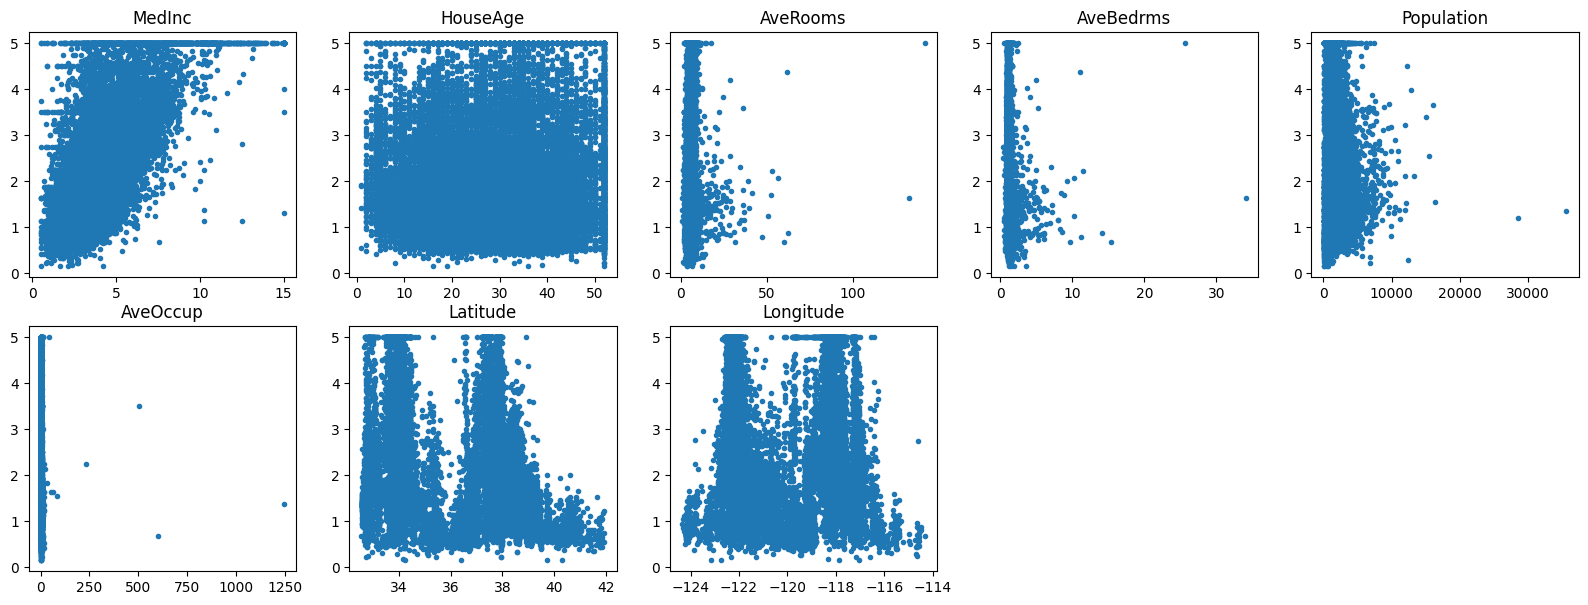

In [ ]:
#fetch data and look at features

housing = fetch_california_housing()

X = housing.data
Y = housing.target

feature_names = housing.feature_names

print('Number of data: %s' %X.shape[0])
D = X.shape[1]

plt.figure( figsize=(20,7))
for d in range (D):
  plt.subplot(2,5,d+1)
  plt.plot(X[:,d],Y,'.',)
  plt.title(feature_names[d])

plt.show()

In [ ]:
#separate data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train_norm = transformer.transform(X_train) # transform() normalizes
X_test_norm =  transformer.transform(X_test)

In [ ]:
print (X_train_norm.shape)
print (X_test_norm.shape)

(8256, 8)
(12384, 8)


In [ ]:
print(Y_train.shape)
print(Y_test.shape)

(8256,)
(12384,)


### 2.

In [ ]:
#train and test a polynomial Ridge

steps = [('poly', PolynomialFeatures()), ('normalize', StandardScaler()), ('clf',Ridge(max_iter = 5000))]

pipe = Pipeline(steps)


pipe.set_params(poly__include_bias=False)
pipe.set_params(clf__fit_intercept=True)

nfold=5

param_grid = [
    {'poly__degree': [1, 2, 3, 4], 'clf__alpha': [1e-6, 1e-4, 0.1, 1, 100]}
]

pipe_grid_search_p_r = GridSearchCV(pipe, param_grid=param_grid, cv=nfold, scoring='neg_mean_squared_error')

pipe_grid_search_p_r.fit(X_train, Y_train)

f_test_p_r = pipe_grid_search_p_r.predict(X_test)

### 3.

In [ ]:
#checking best paramaters and MSE
mse_test_poly_ridge = mean_squared_error(Y_test, f_test_p_r)

best_params_p_r = pipe_grid_search_p_r.best_params_


print('Best parameters: %s' %best_params_p_r)

print('MSE test: %s' %mse_test_poly_ridge )

Best parameters: {'clf__alpha': 100, 'poly__degree': 1}
MSE test: 0.5419219732680354


In [ ]:
#train and test a polynomial Lasso
from warnings import filterwarnings
filterwarnings('ignore')

steps = [('poly', PolynomialFeatures()), ('normalize', StandardScaler()), ('clf',Lasso(max_iter = 5000))]

pipe = Pipeline(steps)


pipe.set_params(poly__include_bias=False)
pipe.set_params(clf__fit_intercept=True)

nfold=5

param_grid = [
    {'poly__degree': [1, 2, 3, 4], 'clf__alpha': [1e-6, 1e-4, 0.1, 1, 100]}
]

pipe_grid_search_l_r = GridSearchCV(pipe, param_grid=param_grid, cv=nfold, scoring='neg_mean_squared_error')

pipe_grid_search_l_r.fit(X_train, Y_train)

f_test_l_r = pipe_grid_search_l_r.predict(X_test)

In [ ]:
#checking best paramaters

mse_test_lasso_poly = mean_squared_error(Y_test, f_test_l_r)

best_params_l_r = pipe_grid_search_l_r.best_params_


print('Best parameters: %s' %best_params_l_r)

print('MSE test: %s' %mse_test_lasso_poly)

Best parameters: {'clf__alpha': 0.1, 'poly__degree': 1}
MSE test: 0.6840701074386895


### 4.

In [ ]:
# training a KNN Regressor with GridSearch to check the best value of k

from sklearn.neighbors import KNeighborsRegressor

K_max = 40
rang_K = np.arange(1, K_max+1)
nfold = 5

pipe = Pipeline([('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])

tuned_parameters  = {
    'kNN__n_neighbors': rang_K
}

grid_pipe = GridSearchCV(pipe, tuned_parameters, cv=nfold, scoring='neg_mean_squared_error')
grid_pipe.fit(X_train, Y_train)
print('GridSearch selected parameter:')
print(grid_pipe.best_params_)

f_test_knn = grid_pipe.predict(X_test)
mse_knn = mean_squared_error(Y_test, f_test_knn)
print('MSE of the pipeline (normalization + KNN): ' + str(mse_knn))

GridSearch selected parameter:
{'kNN__n_neighbors': 12}
MSE of the pipeline (normalization + KNN): 0.42557256728932225


## Answers to the questions:

1.
In both Ridge and Lasso the degree selected is 1 which shows that these models are finding the data to have more of a linear relation, even though that's not what we can see in the graphs (only one of the features has a more or less clear linear relation)

2.
K-NN improves the models because it makes predictions bases on neighboring data points rather than fitting a global relationship across the entire dataset, which in this case may be harder to find, thus the poor performance of the Ridge and Lasso models.

3.
There may be some resons for this:
  - The model may be overfiiting when using higher polynoms of higher degrees.
  - The relationships between variables in the California Housing data set may not require such high order terms. This is mainly because the data seems to have more linear or at least localized relationships.


## 2. Study of feature relevance (3 points)

In this section, using different criteria, you have to analyze the relevance of the input features.
To analyze the feature importances or relevances, you can use the following criteria:

1. **Relevance ranking based on correlation**: as we did in the introductory notebook, use the correlation to define a ranking of the most relevant features. For computing the correlation values, use the training data.

2. **Ridge linear regression weights**: We know that in a linear model *the weight magnitude can be an indicative of the feature relevance*. Train a Ridge Linear Regression model and use its weigth magnitude to generate a ranking of features.

3. Please, **analyze in detail the different results**. Why do these methods provide different results? Point out the advantages/disadvantages of each feature ranking scheme.

4. Use these feature relevances to apply a feature selection (selecting the $3$ most relevant features) and train the polynomial ridge regression model again (note that now you can use a higher polynomial degree, so try the poly degree values $\{1,5,10,15\}$). Do we get to improve the performance of this model? Why? Which feature relevance scheme performs better? Why?

### 1.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# Define the selector method: number of features to select and scoring function
k = 3  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k) #Using f_regression here as correlation based ranking

selector.fit(X_train_norm, Y_train)

X_train_sel = selector.transform(X_train_norm)
X_test_sel = selector.transform(X_test_norm)

# Get a boolean mask indicating the selected features
mask = selector.get_support()

# Get the selected feature names
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if mask[i]]

# Print the results in a cleaner format
print(f"Top {k} selected features based on f_regression scoring:")
for i, feature in enumerate(selected_feature_names, start=1):
    print(f"{i}. {feature}")

# Check dimensions of the selected data sets
print("\nDimension of the selected train data set:", X_train_sel.shape)
print("Dimension of the selected test data set:", X_test_sel.shape)


Top 3 selected features based on f_regression scoring:
1. MedInc
2. AveRooms
3. Latitude

Dimension of the selected train data set: (8256, 3)
Dimension of the selected test data set: (12384, 3)


### 2.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge

# Train the Ridge Linear Regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_norm, Y_train)

# Get the coefficients (weights)
coefficients = ridge.coef_

# Create a DataFrame to store the feature names, indices, and their corresponding weights
feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Feature Index': range(len(coefficients)),
    'Weight': coefficients,
    'Absolute Weight': np.abs(coefficients)  # Use absolute weights for ranking
})

# Sort the DataFrame by absolute weight
feature_ranking = feature_ranking.sort_values(by='Absolute Weight', ascending=False)

# Select the top 3 feature indices
top_3_indices = feature_ranking['Feature Index'].head(3).tolist()
print("\nTop 3 feature indices:", top_3_indices)
print("Corresponding feature names:", feature_ranking['Feature'].head(3).tolist())



Top 3 feature indices: [6, 0, 7]
Corresponding feature names: ['Latitude', 'MedInc', 'Longitude']


**SelectKBest Features:**

MedInc, AveRoom, Latitude

**Ridge Regression Features:**

Latitude, MedInc, Longitude

### 3.

SelectKBest using the f_regression method and Ridge Regression serve different purposes in feature selection, which explains why their outputs regarding feature relevance can differ significantly.

####1. Approach to Feature Evaluation:
- SelectKBest (f_regression): Uses univariate feature selection, evaluating each feature independently in relation to the target variable.
- Ridge Regression: Considers all features simultaneously, assigning weights based on their collective impact on the prediction.

####2. Relationship Assumptions:
- f_regression in SelectKBest: Assumes linear relationships between individual features and the target.
- Ridge Regression: While also linear, it considers the collective linear relationships of all features with the target.

####3. Feature Interactions:
- SelectKBest: Does not account for interactions between features.
- Ridge Regression: Implicitly captures feature interactions by considering their collective impact, which can be beneficial when these features are later used in polynomial models.

####4. Regularization:
- SelectKBest: Does not incorporate regularization in its selection process.
- Ridge Regression: Includes L2 regularization, which helps in managing multicollinearity and can prevent overfitting in feature selection.


####Advantages and Disadvantages:

SelectKBest (f_regression):

- Advantages: Simple, computationally efficient method for feature selection. Useful for understanding individual feature importance.
- Disadvantages: May miss important feature interactions. Lacks regularization, which can be crucial in high-dimensional spaces.

Ridge Regression:

- Advantages: Better at handling complex feature relationships. Incorporates regularization, which is beneficial for both feature selection and model performance, especially in polynomial models.
- Disadvantages: May be more computationally intensive for very large datasets. The interpretation of feature importance can be less straightforward compared to univariate methods.


### 4.

First training with the features coming from SelectKbest

In [ ]:
#Running a pipeline like before with grid search to find best paramaters

steps = [('poly', PolynomialFeatures()), ('normalize', StandardScaler()), ('clf',Ridge(max_iter = 5000))]

pipe = Pipeline(steps)


pipe.set_params(poly__include_bias=False)
pipe.set_params(clf__fit_intercept=True)

nfold=5

param_grid = [
    {'poly__degree': [1, 5, 10, 15], 'clf__alpha': [1e-6, 1e-4, 0.1, 1, 100]}
]

pipe_grid_search_fr = GridSearchCV(pipe, param_grid=param_grid, cv=nfold, scoring='neg_mean_squared_error')

pipe_grid_search_fr.fit(X_train_sel, Y_train) # I can jsut use the X_train_sel here, which already contains the features selected by f_regression

f_test_fr = pipe_grid_search_fr.predict(X_test_sel)

In [ ]:
#checking best paramaters

mse_test_kbest3_poly = mean_squared_error(Y_test, f_test_fr)

best_params = pipe_grid_search_fr.best_params_


print('Best parameters: %s' %best_params)

print('MSE test: %s' %mse_test_kbest3_poly)

Best parameters: {'clf__alpha': 100, 'poly__degree': 1}
MSE test: 0.698390252810304


We can see that the MSE is poor. Besides that the alpha is very high, which means that the penalty is huge for the selected features. Also the polynomial degree is very low, so it's assuming the features have linear relations which is not the case.

Now doing the same for the features selected by ridge

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_train_norm.shape)
print(X_test_norm.shape)

(8256, 8)
(12384, 8)
(8256, 8)
(12384, 8)


In [ ]:
#train and test a polynomial Ridge but with the selected 3 best features

# Convert X_train and X_test to Pandas DataFrames if they are NumPy arrays. I was having problems with features when using Numpy instead of Pandas
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

#train and test a polynomial Ridge but with the selected 3 best features

X_train_top3 = X_train.iloc[:,top_3_indices]
X_test_top3 = X_test.iloc[:,top_3_indices]

In [ ]:
print(X_train_top3.shape)
print(X_test_top3.shape)

(8256, 3)
(12384, 3)


In [ ]:
steps = [('poly', PolynomialFeatures()), ('normalize', StandardScaler()), ('clf',Ridge(max_iter = 5000))]

pipe = Pipeline(steps)


pipe.set_params(poly__include_bias=False)
pipe.set_params(clf__fit_intercept=True)

nfold=5

param_grid = [
    {'poly__degree': [1, 5, 10, 15], 'clf__alpha': [1e-6, 1e-4, 0.1, 1, 100]}
]

pipe_grid_search_lr3 = GridSearchCV(pipe, param_grid=param_grid, cv=nfold, scoring='neg_mean_squared_error')

pipe_grid_search_lr3.fit(X_train_top3, Y_train)

f_test_lr3 = pipe_grid_search_lr3.predict(X_test_top3)

In [ ]:
#checking best paramaters

mse_test_ridge3_poly = mean_squared_error(Y_test, f_test_lr3)

best_params = pipe_grid_search_lr3.best_params_

print('Best parameters: %s' %best_params)

print('MSE test: %s' %mse_test_ridge3_poly)


Best parameters: {'clf__alpha': 1e-06, 'poly__degree': 15}
MSE test: 0.4675420115734476


Answer: The feature selection improves the original Polynomial Ridge Regression model performance, but only for the features that were chosen by Ridge and not from correlation. This is due to the reasons defined before. The correlation method doesn't take into account the target variables. We can see that the features selected by Ridge also make the GridSearch choose a much higher degree polynom, which means these features make the model capture much more complex relationships. At the same time the best value of alpha is the lowest one, which means there is a very low penalty, showing that these features are relevant

# 3. Feature selection for non-linear models (3 points)

The above criteria for selecting variables are linear and then we are using a non-linear regressor, that is not the most appropriate. In this last section we are going to analyze the advantages of using a non-linear feature selection. So, implement and evaluate the performance of the following feature selection methods.

1. **[Mutual Information (MI)](https://en.wikipedia.org/wiki/Mutual_information)** as relevance criteria for feature ranking. Unlike correlation, MI is able to detect no-linear relationships between varaibles. Using the function [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) obtain a ranking of variables based on MI and compute the performance provided with the 3 most relevant features over a Polynomial Ridge Regression model.


2. **Greedy search based on the validation error**: Other feature selection scheme can consist in training a classifier with a given subset of features and evalaute its validation error to analyze whether this selection is good or not.However, exploring all possible subsets  is usually computationally unflexible (there are $2^D$ combinations!!!!); so a greedy search (fordward or backward) is usually prefered:

  2.1 *Forward search*: It starts with an empty set and, iteratively, adds new features according to a relevance criterion (in this case, minimum validation MSE).

  <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/Fig_Forward_search.png" width="48%" >

  2.2 *Backward search*: It starts considering all the features and, iteratively, removes features according to a relevance criterion (in this case, minimum validation MSE).

  <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/Fig_Backward_search.png" width="48%" >


Discuss which of these strategies is most appropriate for use with a polymial Ridge Regression model. For the selected option, implement it and analyze the selected set of the three most relevant features, as well as its performance.



###1.

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_train_norm.shape)
print(X_test_norm.shape)

(8256, 8)
(12384, 8)
(8256, 8)
(12384, 8)


In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_train_norm, Y_train)

In [ ]:
#Select 3 best features from method

# Create a dataframe of features and their MI scores
mi_ranking = pd.DataFrame({
    'Feature Index': range(len(mi_scores)),
    'Feature': feature_names,
    'Mutual Information': mi_scores
})

mi_ranking = mi_ranking.sort_values('Mutual Information', ascending=False)

print(mi_ranking)

   Feature Index     Feature  Mutual Information
7              7   Longitude            0.388941
0              0      MedInc            0.361969
6              6    Latitude            0.348143
2              2    AveRooms            0.097611
5              5    AveOccup            0.066808
1              1    HouseAge            0.036429
3              3   AveBedrms            0.016744
4              4  Population            0.014439


In [ ]:
top_3_mi = mi_ranking['Feature Index'].head(3).tolist()

X_train_top_mi = X_train.iloc[:,top_3_mi]
X_test_top_mi = X_test.iloc[:,top_3_mi]

In [ ]:
print(X_train_top_mi.shape)
print(X_test_top_mi.shape)

(8256, 3)
(12384, 3)


In [ ]:
steps = [('poly', PolynomialFeatures()), ('normalize', StandardScaler()), ('clf',Ridge(max_iter = 5000))]

pipe = Pipeline(steps)


pipe.set_params(poly__include_bias=False)
pipe.set_params(clf__fit_intercept=True)

nfold=5

param_grid = [
    {'poly__degree': [1, 5, 10, 15], 'clf__alpha': [1e-6, 1e-4, 0.1, 1, 100]}
]

pipe_grid_search_mi = GridSearchCV(pipe, param_grid=param_grid, cv=nfold, scoring='neg_mean_squared_error')

pipe_grid_search_mi.fit(X_train_top_mi, Y_train)

f_test_mi = pipe_grid_search_mi.predict(X_test_top_mi)

In [ ]:
#checking best paramaters

mse_test_mi_poly = mean_squared_error(Y_test, f_test_mi)

best_params = pipe_grid_search_mi.best_params_

print('Best parameters: %s' %best_params)

print('MSE test: %s' %mse_test_mi_poly)


Best parameters: {'clf__alpha': 1e-06, 'poly__degree': 15}
MSE test: 0.4675420006990765


###2.


Forward Search can miss important feature interactions and may get stuck in local optima, potentially overlooking better feature combinations.

For Polynomial Regression models, Backward Search is more appropriate. It starts with all features, allowing it to capture complex data relationships from the beginning. This approach aligns better with polynomial models, which inherently consider feature interactions. Backward Search thus provides a more comprehensive evaluation of feature importance in this context, leading to potentially better feature selection for polynomial regression.

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_train_norm.shape)
print(X_test_norm.shape)

(8256, 8)
(12384, 8)
(8256, 8)
(12384, 8)


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

# Create the SequentialFeatureSelector for backward selection
selector = SequentialFeatureSelector(
    ridge,
    n_features_to_select=3,
    direction='backward', #here I selected backward to create the backward selection
)

# Create the pipeline
steps = [
    ('normalize', StandardScaler()),
    ('selector', selector),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('clf', Ridge(max_iter=5000, fit_intercept=True))
]

pipe = Pipeline(steps)

# Set up the parameter grid
param_grid = [
    {'poly__degree': [1, 5, 10, 15], 'clf__alpha': [1e-6, 1e-4, 0.1, 1, 100]}
]

# Set up the grid search
nfold = 5
pipe_grid_search_bws = GridSearchCV(pipe, param_grid=param_grid, cv=nfold, scoring='neg_mean_squared_error')


pipe_grid_search_bws.fit(X_train, Y_train)

selected_features_mask = pipe_grid_search_bws.best_estimator_.named_steps['selector'].get_support()
selected_features = X_train.columns[selected_features_mask].tolist()
print("Selected features:", selected_features)

# Transform the test set according to the pipeline up to the feature selection step
X_test_transformed = pipe_grid_search_bws.best_estimator_.named_steps['selector'].transform(X_test)
print("Shape of X_test after feature selection:", X_test_transformed.shape)

Selected features: [0, 6, 7]
Shape of X_test after feature selection: (12384, 3)


In [ ]:
# Make predictions
Y_pred = pipe_grid_search_bws.predict(X_test)

mse_backward_search = mean_squared_error(Y_test, Y_pred)
print(f"MSE on test set: {mse_backward_search}")
print("Best parameters:", pipe_grid_search_bws.best_params_)


MSE on test set: 0.45683643128002616
Best parameters: {'clf__alpha': 0.1, 'poly__degree': 5}


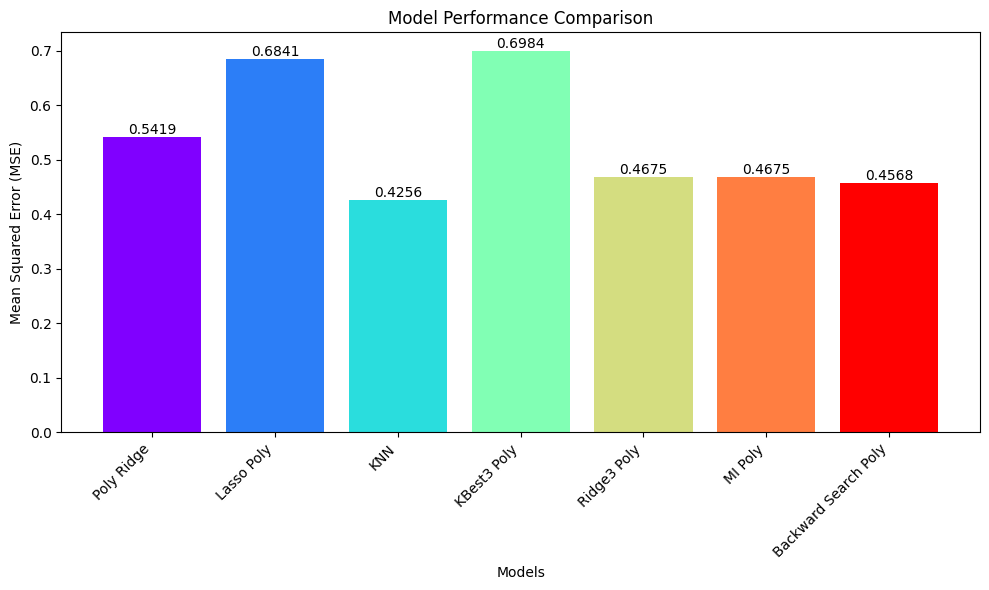

In [ ]:
import matplotlib.pyplot as plt

# MSE values for each model
mse_values = [mse_test_poly_ridge, mse_test_lasso_poly, mse_knn, mse_test_kbest3_poly, mse_test_ridge3_poly, mse_test_mi_poly, mse_backward_search]

# Names for each model
model_names = ['Poly Ridge', 'Lasso Poly', 'KNN', 'KBest3 Poly', 'Ridge3 Poly', 'MI Poly', 'Backward Search Poly']

# Create a color palette
colors = plt.cm.rainbow(np.linspace(0, 1, len(model_names)))

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mse_values, color=colors)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

#Conclusion:

After analyzing the results I can take the following conclusions:
- The model isn't supposed to be a linear one. Even with selected features and high degree polynom, the MSE is still very high. We can clearly see that the features don't have a linear relation.
- Even when selecting methods for non-linear selection, like MI and Backward Search, we are still inputing those features into a linear model, so the outcome ends up being pretty similar to what we were getting before with the  features selected by the Ridge model.
- The KNN model is the one that performs better because it does not assume that the features have a linear relation.
- If I were to repeat this experiment I would try using different models, non-linear ones, combined with non-linear methods of discovering feature relevance
- I would use more than 3 features to compare the different selection methods better. For example I tried for experimentation purposes see the 4 most relevant features using ridge and mi and in this case the last (4th) feature was different which would have resulted in a different mse as well.